In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import vaemof
from vaemof import experiments
from vaemof import utils
from vaemof.vocabs import SELFIESVocab, MOFVocab, PropVocab
from vaemof import modules
from vaemof import training
from vaemof.model import VAEMOF
from vaemof import configs

from vaemof.utils import header_str
vaemof.experiments.plot_settings()

In [32]:
import os
import random
from tqdm.auto import tqdm
import numpy as np
import torch
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from itertools import product
from more_itertools import chunked
from collections import OrderedDict
from rdkit.Chem import PandasTools
from IPython.display import SVG, display
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

print(f'rdkit : {rdkit.__version__}')
print(f'torch : {torch.__version__}')
print(f'cuda? {torch.cuda.is_available()}')
tqdm.pandas()
utils.disable_rdkit_log()

rdkit : 2019.09.3
torch : 1.4.0
cuda? True


## Hparams and model

In [33]:
WORK_DIR = 'results/best/'
hparams_file = os.path.join(WORK_DIR,'config.json')
hparams = configs.AttributeDict.from_jsonfile(hparams_file)
hparams['train_device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
utils.set_seed(hparams['train_seed'])
device = torch.device(hparams['train_device'])
configs.print_config(hparams)
model = VAEMOF.load(hparams)

==================================== config ====================================
== train == :
        train_device:                cuda
          train_seed:                  42
    train_batch_size:                1536
        train_epochs:                 120
            train_lr:0.0005705023000000001
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 288
           vae_y_dec:                True
     vae_selfies_dec:                True
         vae_mof_enc:                True
         vae_mof_dec:                True
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                cats
   mof_weighted_loss:                True
         mof_w_start:                 0.0
           mof_w_end:                 0.1
           mof_start:                   0
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld', 'density', 'agsa', 'co2n2_co2_mol_kg', 'co2n2_n2_mol_kg', 'co2ch4_co2_mol_kg',

## Load MOF data

Assemble smiles formula: [organic core][metal_node][topology][branch_smiles]

In [34]:
smiles_column = 'branch_smiles'
testtrain_column = 'train/test'
df = experiments.get_generator_df(csv_file=hparams['files_data'],
                                  smiles_column=smiles_column,
                                  use_duplicates=hparams['vae_duplicate_smiles'],
                                  testing=False)
ids2mofs, mof2ids, mof_columns = experiments.get_mofdict(
    df, hparams['mof_encoding'])
df.head()

=================================== Real run ===================================
df shape: (2049964, 8)
df columns: ['branch_smiles', 'id2mof', 'metal_node', 'mof_index', 'organic_core', 'randomized', 'topology', 'train/test']
Found 713 unique mofs


branch_smiles  id2mof  metal_node  \
0  CC(c1cc(O)cc(O)c1)(C(Sc1cc(O)cc(O)c1)c1cc(O)cc...       0  sym_7_mc_4   
1  Oc1ccc(-c2cc(/C=C/c3c(-c4ccc(O)cc4)cc([Lr])c(-...       0  sym_7_mc_4   
2  O=S(=O)(O)Cc1nn([Lr])c(CS(=O)(=O)O)c1-c1c(CS(=...       0  sym_7_mc_4   
3  [Lr]c1ccc(-c2c(-c3ccccc3)cc([Lr])c(-c3ccccc3)c...       0  sym_7_mc_4   
4  [Lr]c1ccc(N2C=C(c3ccncc3)N(c3c(-c4ccncc4)cc([L...       0  sym_7_mc_4   

   mof_index organic_core  randomized topology  train/test  
0        4.0         None       False      acs           1  
1       10.0         None       False      acs           1  
2       18.0         None       False      acs           1  
3       23.0         None       False      acs           1  
4       29.0         None       False      acs           1

## Load property data

In [35]:
prop_df = experiments.get_prop_df(csv_file=hparams['files_prop'],
                                  targets=hparams['y_labels'],
                                  mof2ids=mof2ids,
                                  testing=False,
                                  smiles_column=smiles_column,
                                  compute_scscore=True)
prop_df.head()

=================================== Real run ===================================
Restored variables from data/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz



Removed 2923 datapoints due to mask.
Removed 1819 datapoints due non-valid mof (mof2ids).


organic_core  metal_node topology  \
0         None  sym_7_mc_4      acs   
1         None  sym_7_mc_4      acs   
2         None  sym_7_mc_4      acs   
3         None  sym_7_mc_4      acs   
4         None  sym_7_mc_4      acs   

                                       branch_smiles       lcd       pld  \
0  COc1c(/C=C/c2ccc([Lr])cc2)cc(OC)c(/C=C/c3ccc([...  24.87798  19.29733   
1         CSC1=C2CCC(=C(C(=C2SC)[Lr])SC)C(=C1[Lr])SC   7.78281   5.18969   
2   O=C(c1cc(O)c(cc1O)[Lr])OOC(=O)c1cc(O)c(cc1O)[Lr]  17.01677  15.91720   
3   Oc1c(cc(c(c1O)[Lr])O)c1nnc(nn1)c1ccc(c(c1)O)[Lr]  19.50569  17.17410   
4                        [Lr]C12C=CC(C=C1)(C=C2)[Lr]   9.58653   8.21739   

    density      agsa  co2n2_co2_mol_kg  co2n2_n2_mol_kg  co2ch4_co2_mol_kg  \
0  0.164554  7044.060          0.144618         0.349278           0.581987   
1  1.119280   874.575          0.146916         0.080829           0.528460   
2  0.320703  5078.290          0.161247         0.200035           0.645542   
3  0.291374  4810.800          0.123371         0.206453           0.476879   
4  0.799733  2526.910          0.187598         0.182757           0.662801   

   co2ch4_ch4_mol_kg  selfies_safe  mask  train/test   scscore  id2mof  
0           2.931209          True  True           1  3.384814       0  
1           1.487603          True  True           0  3.176298       0  
2           1.933800          True  True           1  2.668208       0  
3           1.906831          True  True           1  3.688210       0  
4           2.751822          True  True           1  1.831772       0

## Train/test splits and hparams

In [36]:
train_index = np.array(df[df[testtrain_column] == 1].index.tolist())
test_index = np.array(df[df[testtrain_column] == 0].index.tolist())
prop_train_index = np.array(
    prop_df[prop_df[testtrain_column] == 1].index.tolist())
prop_test_index = np.array(
    prop_df[prop_df[testtrain_column] == 0].index.tolist())
print(f'Test  sizes: {len(test_index):7d} and {len(prop_test_index):7d}')

Test  sizes:  154997 and    4132


## Prepare tain/test

In [37]:
train_mof = model.df_to_tuples(df.loc[train_index], smiles_column)
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_train = model.df_to_tuples(prop_df.loc[prop_train_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
train_data = train_mof + prop_train
test_data = test_mof + prop_test

## Properties

In [38]:
print(header_str('R^2 scores and MAEs'))
src_data = prop_test
batch_size = 256
n_loops = int(np.ceil(len(src_data) / batch_size))
y_pred, y_true = [], []
for chunk in  tqdm(chunked(src_data,batch_size),total=n_loops, desc='Pred'):
    batch = model.tuples_to_tensors(chunk)
    z = model.inputs_to_z(batch['x'],batch['mof'])
    outs = model.z_to_outputs(z)
    y_true.extend(model.vocab_y.inverse_transform(batch['y']))
    y_pred.extend(outs['y'])
    
y_pred = np.stack(y_pred)
y_true = np.stack(y_true)
experiments.regression_statistics(y_true, y_pred, hparams['y_labels'])

============================= R^2 scores and MAEs ==============================



lcd , R2:  0.8942273453112742 , MAE:  2.899597 , RMSE:  4.365679
pld , R2:  0.885247210491716 , MAE:  2.6684234 , RMSE:  4.143108
density , R2:  0.815641519033826 , MAE:  0.08144474 , RMSE:  0.12105584
agsa , R2:  0.8767314991192416 , MAE:  405.9308 , RMSE:  622.61835
co2n2_co2_mol_kg , R2:  0.2130571346882476 , MAE:  0.100122884 , RMSE:  0.22745004
co2n2_n2_mol_kg , R2:  0.8166076325920332 , MAE:  0.041701663 , RMSE:  0.067280665
co2ch4_co2_mol_kg , R2:  0.2510281862634469 , MAE:  0.19794047 , RMSE:  0.38340002
co2ch4_ch4_mol_kg , R2:  0.6030804803517182 , MAE:  0.3591167 , RMSE:  0.58265567


label        R2         MAE        RMSE
0                lcd  0.894227    2.899597    4.365679
1                pld  0.885247    2.668423    4.143108
2            density  0.815642    0.081445    0.121056
3               agsa  0.876731  405.930786  622.618347
4   co2n2_co2_mol_kg  0.213057    0.100123    0.227450
5    co2n2_n2_mol_kg  0.816608    0.041702    0.067281
6  co2ch4_co2_mol_kg  0.251028    0.197940    0.383400
7  co2ch4_ch4_mol_kg  0.603080    0.359117    0.582656

## Prior check

In [39]:
print(header_str('prior'))
n = 10000
gen_df = experiments.sample_model(model, n)
print('valid smiles: {} out of {} ({}%)'.format(gen_df['valid'].sum(),n,gen_df['valid'].sum()/n*100.0))
gen_df.head(2)

==================================== prior =====================================



valid smiles: 6260 out of 10000 (62.6%)


branch_smiles  valid  metal_node  \
0  O=S(O)c1cc([Lr])ccc1N1C=CCCSC2=C[SH]1(=O)OC=CC...   True  sym_8_mc_7   
1  O=co1c2c(O)c([Lr])cc(O)c2c(=O)cc2(O)c([Lr])c(O...  False  sym_5_mc_2   

  organic_core topology        lcd        pld   density         agsa  \
0  sym_5_on_12      scu  31.095848  29.406397  0.250225  7707.727539   
1  sym_5_on_11      ssa  36.152397  14.945479  0.001991  5264.557129   

   co2n2_co2_mol_kg  co2n2_n2_mol_kg  co2ch4_co2_mol_kg  co2ch4_ch4_mol_kg  
0          0.342026         0.326753           0.870238           2.938891  
1          0.271666         0.268978           0.800976           3.006456

## Posterior check

In [45]:
print(header_str('Posterior check'))

tries=10
sub_sample =1000
src_data = train_data
src_data = random.sample(src_data,min(len(src_data),sub_sample))
valid_smiles=[]
recon_smiles=[]
n = len(src_data)
results=[]
mof_results=[]
for t in tqdm(src_data):
    batch = [t]*tries
    batch = model.tuples_to_tensors(batch)
    z = model.inputs_to_z(batch['x'],batch['mof'])
    outs = model.z_to_outputs(z)
    true_smiles = vaemof.vocabs.isosmiles(model.vocab.ids_to_string(t[0]))
    true_mof = model.vocab_mof.ids_to_mof(t[1])
    smiles_list = outs['x']
    mof_list = outs['mof']
    acc_mof = any([ all(i==true_mof) for i in np.array(mof_list)])
    valid_smiles = [si for si in set(smiles_list) if vaemof.vocabs.valid_smiles(si)]
    valid_smiles = [vaemof.vocabs.isosmiles(si) for si in valid_smiles]
    same_smiles = [si for si in valid_smiles if si==true_smiles]
    results.append([true_smiles, smiles_list[0], len(same_smiles)>0,len(valid_smiles)>0])
    mof_results.append(acc_mof)
        
post_df = pd.DataFrame(results,columns=['smiles','recon_smiles','same','valid'])
print('valid: {} out of {} ({:.2f}%)'.format(post_df['valid'].sum(),n,post_df['valid'].sum()/n*100.0))
print('same : {} out of {} ({:.2f}%)'.format(post_df['same'].sum(),n,post_df['same'].sum()/n*100.0))
print('MOF recon acc: {}'.format(float(sum(mof_results))/float(len(mof_results))))

=============================== Posterior check ================================



valid: 997 out of 1000 (99.70%)
same : 986 out of 1000 (98.60%)
MOF recon acc: 1.0


## PCA analysis of the latent space

In [46]:
sub_sample = 100000
src_data = prop_train
src_data = random.sample(src_data,min(len(src_data),sub_sample))
n = len(src_data)
batch_size=64
n_loops = int(np.ceil(n/batch_size))
z=[]
y=[]
for chunk in tqdm(chunked(src_data,batch_size),total=n_loops, desc='Generating predictions'):
    batch = model.tuples_to_tensors(chunk)
    y.extend(model.vocab_y.inverse_transform(batch['y']))
    z_tensor = model.inputs_to_z(batch['x'],batch['mof'])
    z.extend(z_tensor.cpu().numpy())
        
z = np.stack(z)
z_pca = PCA(2).fit_transform(z)
z_y_df = pd.DataFrame(y,columns=hparams.y_labels)
z_y_df['x']=z_pca[:,0]
z_y_df['y']=z_pca[:,1]
print(z.shape)
z_y_df.head()


(37015, 288)


lcd        pld   density         agsa  co2n2_co2_mol_kg  \
0  44.261200  42.217072  0.136443  6782.180176          0.167101   
1  24.026661  18.124750  0.278945  4982.669922          0.362002   
2  38.997818  28.230560  0.147630  5530.299805          0.195254   
3  58.044029  28.340569  0.082806  7275.549805          0.241783   
4  79.030479  43.414001  0.062559  7276.509766          0.226110   

   co2n2_n2_mol_kg  co2ch4_co2_mol_kg  co2ch4_ch4_mol_kg         x         y  
0         0.388984           0.975033           2.972816  3.208280  1.273755  
1         0.291997           1.172927           3.329636  0.693272 -1.247443  
2         0.359734           0.607551           2.698548  1.235378 -1.100466  
3         0.565766           0.778815           3.990939  2.594513 -0.882076  
4         0.705228           0.745158           4.691043  3.738854 -0.959954

===================================== lcd ======================================


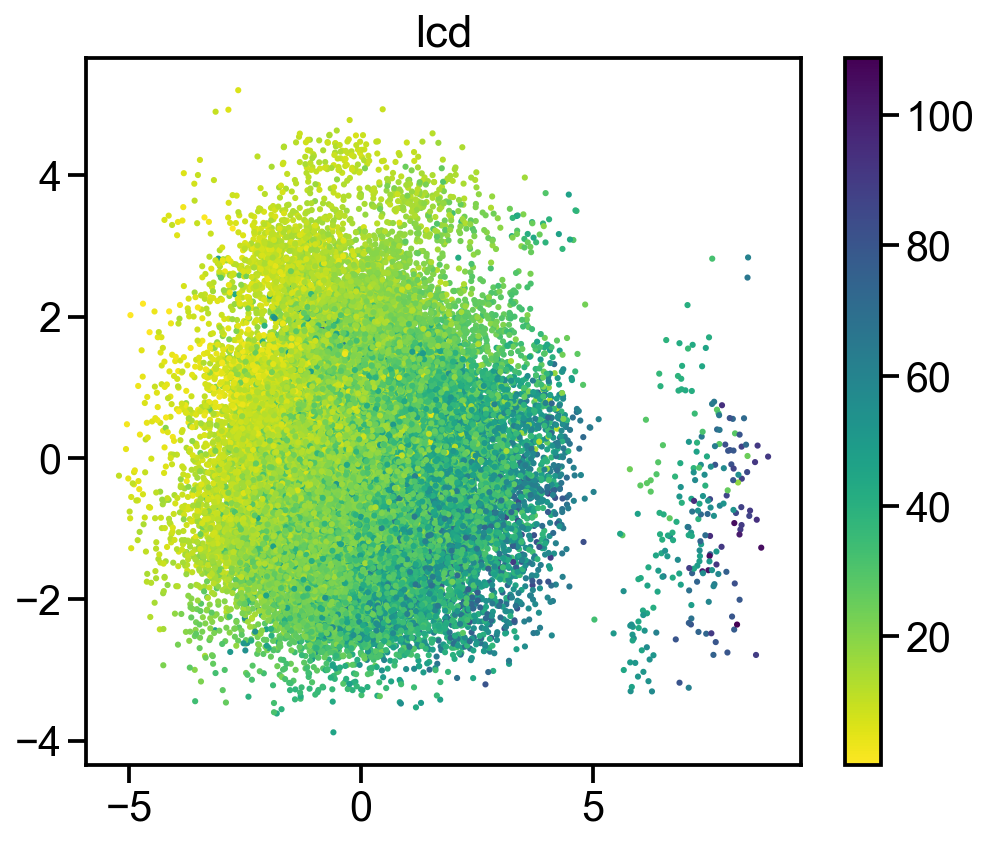

===================================== pld ======================================


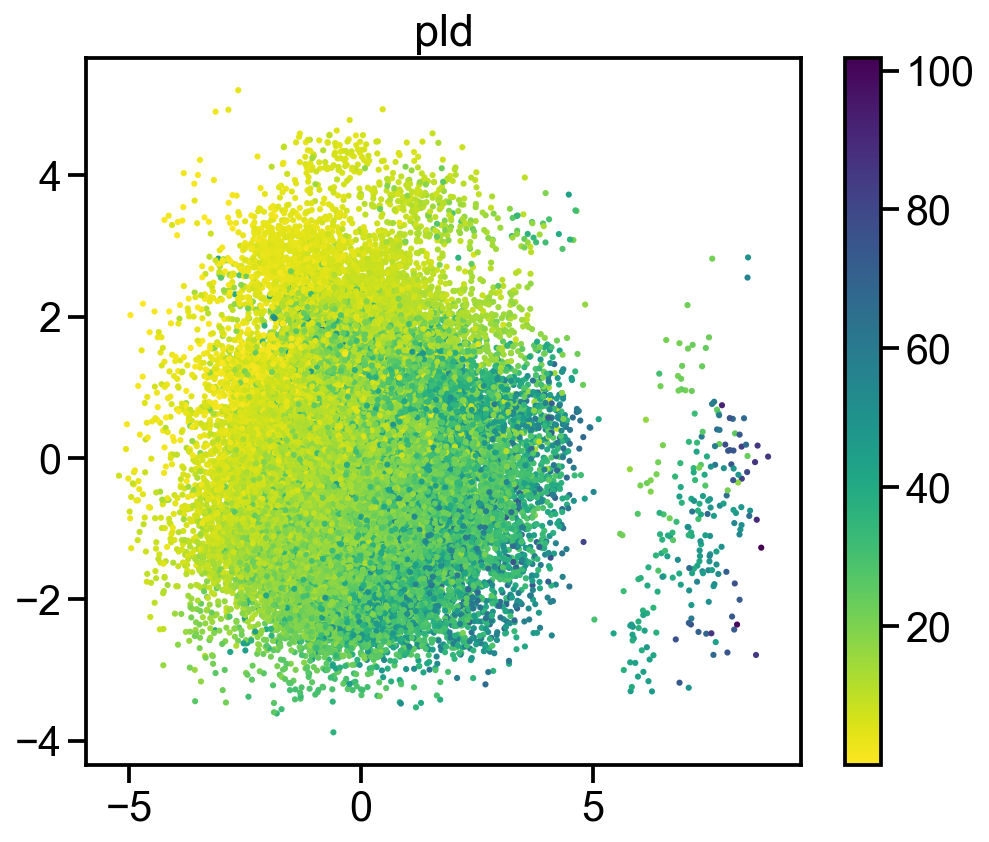

=================================== density ====================================


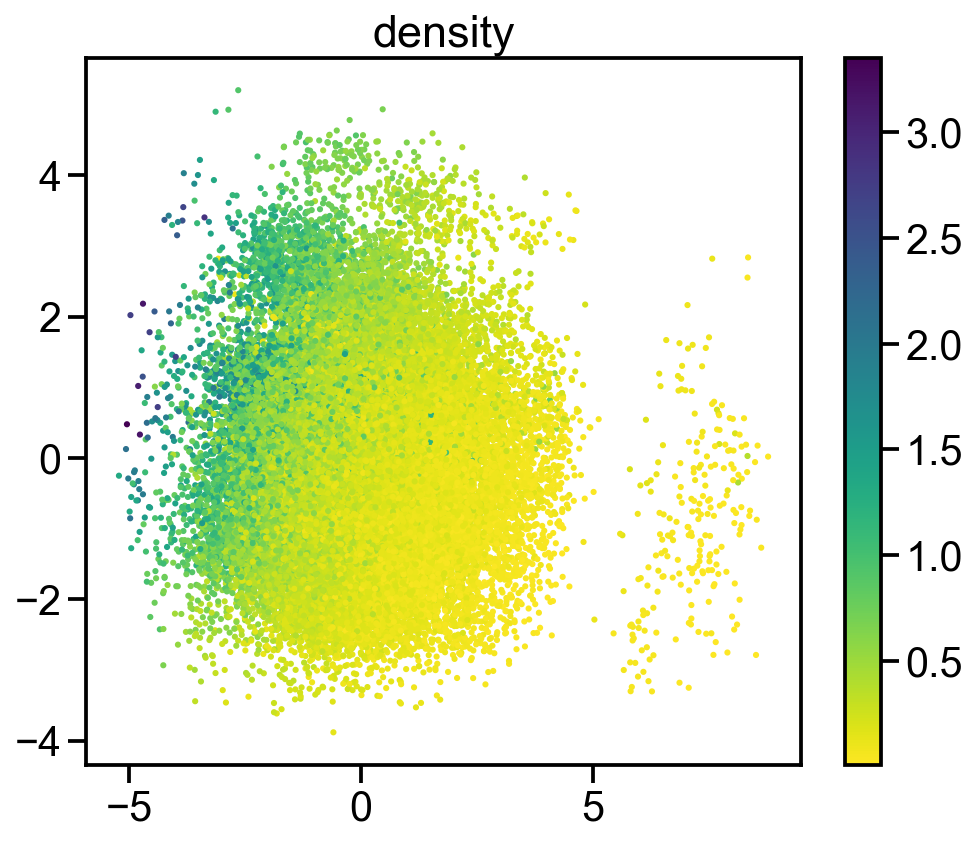

===================================== agsa =====================================


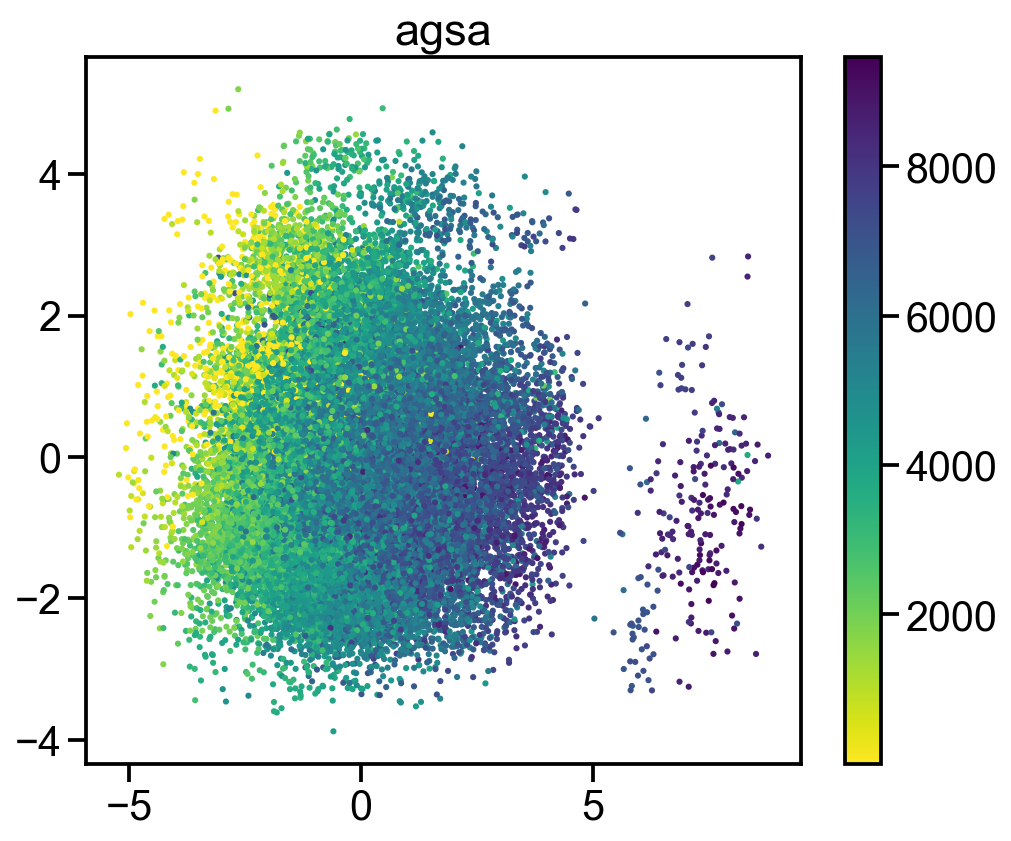

=============================== co2n2_co2_mol_kg ===============================


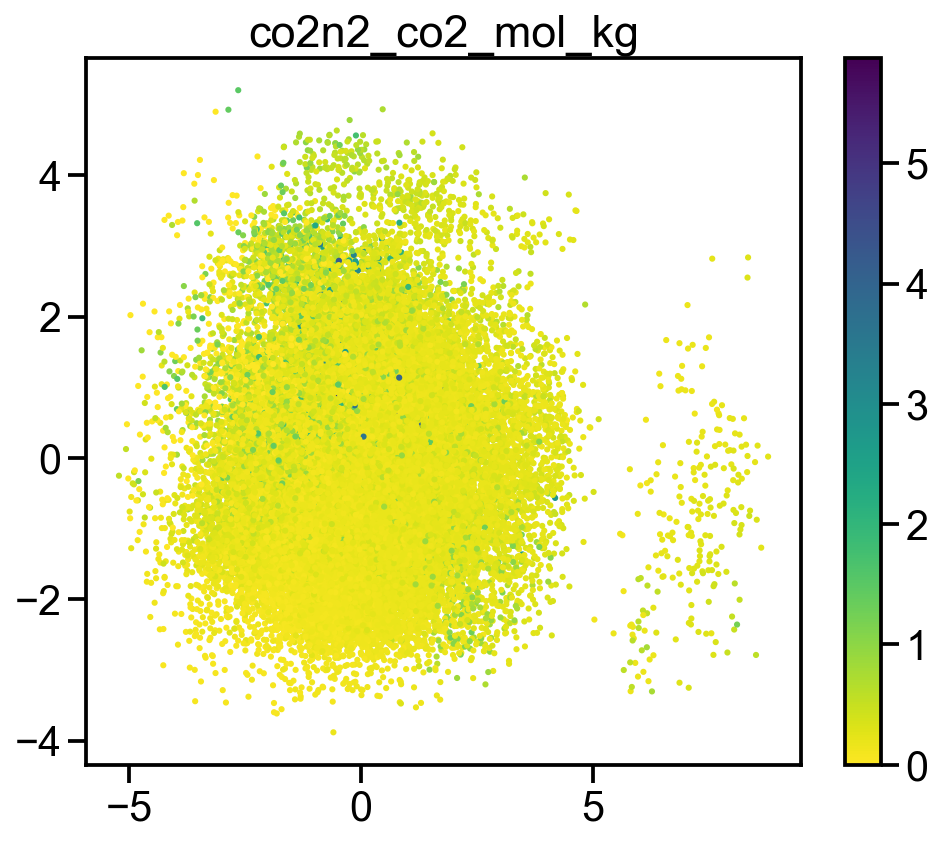

=============================== co2n2_n2_mol_kg ================================


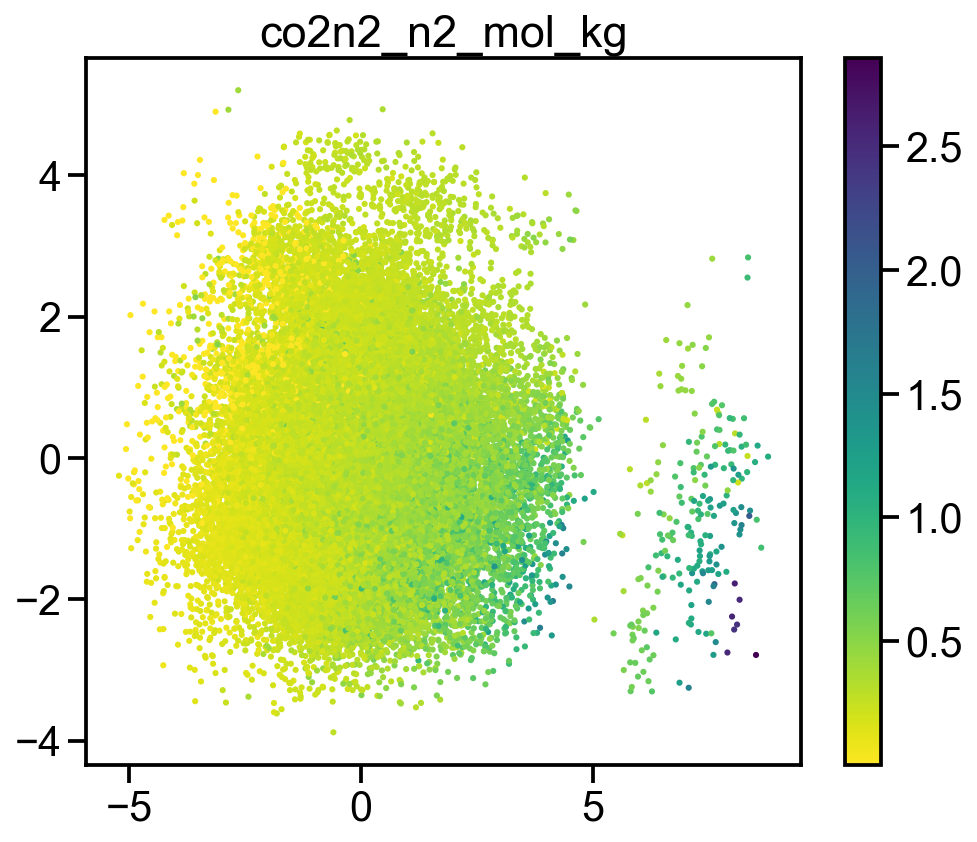

============================== co2ch4_co2_mol_kg ===============================


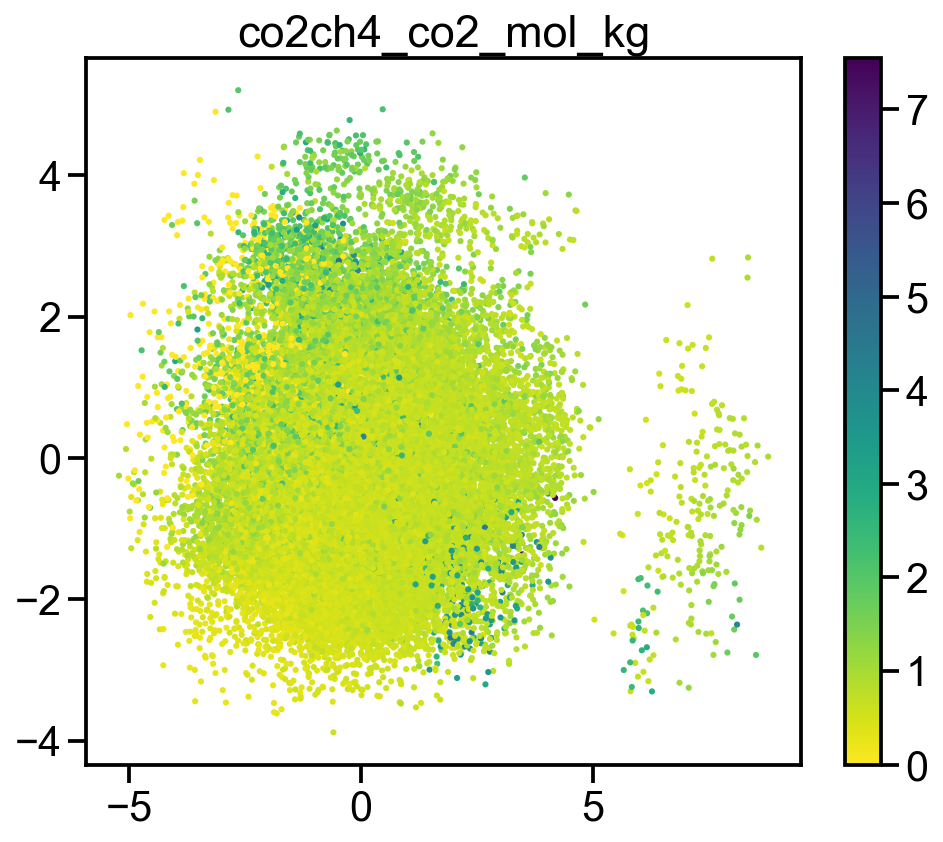

============================== co2ch4_ch4_mol_kg ===============================


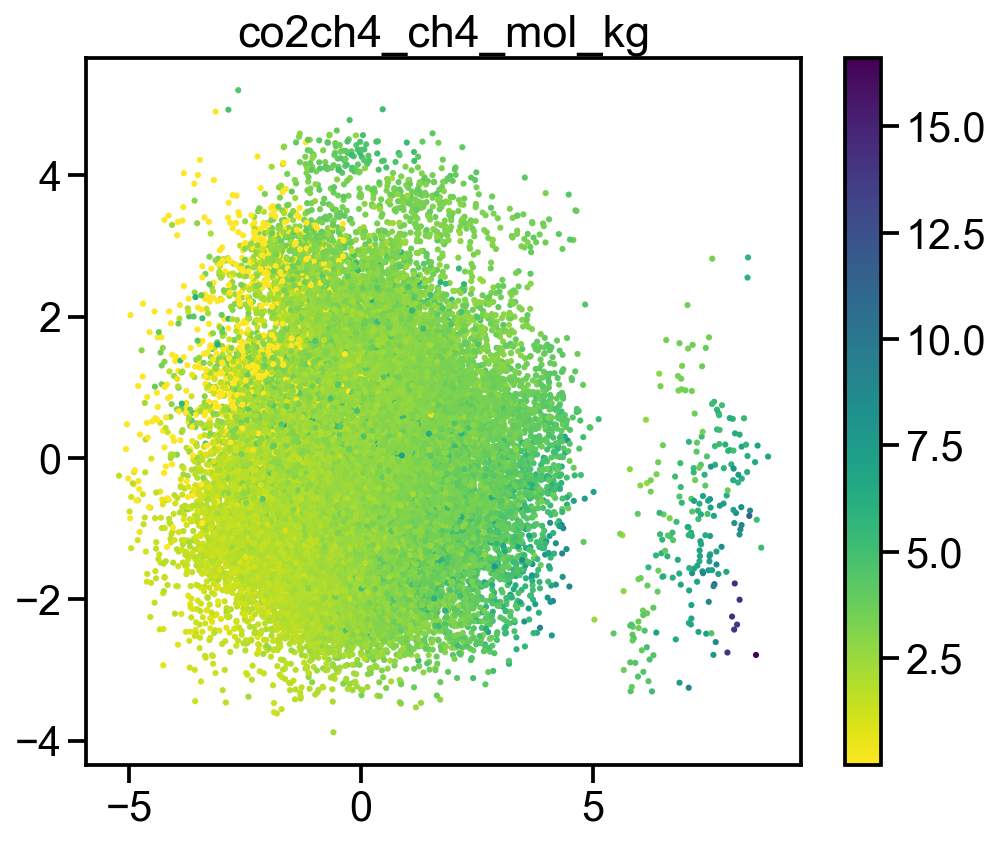

In [47]:
cmap='viridis_r'
for index,col in enumerate(hparams.y_labels):
    print(header_str(col))
    plt.figure(figsize=(8,6.5))
    scatter = plt.scatter(z_y_df['x'],z_y_df['y'],c=z_y_df[col], s=2.5,lw=1.5,cmap=cmap,edgecolor=None)
    plt.colorbar(scatter)
    plt.title(col)
    plt.savefig('images/%s-%s.png'%(col,cmap),dpi=300,transparent=True)
    plt.show()

## Sampling the neighboring space of known MOF

In [62]:
nu_1104 = [('sym_5_on_12','sym_12_mc_11','ftw','[Lr]c1ccc(C#Cc2ccc([Lr])cc2)cc1',0.0)]
nu_df = pd.DataFrame(nu_1104,columns=['organic_core','metal_node','topology','branch_smiles','dist'])
nu_tuple = model.df_to_tuples(nu_df, smiles_column)
nu_tensor = model.tuples_to_tensors(nu_tuple)
nu_z = model.inputs_to_z(nu_tensor['x'],nu_tensor['mof'])

In [63]:
i = 0
tries = 100
noise_max = 20
while i < tries:
    sample = []
    noise = random.uniform(0,noise_max)
    sample_z = experiments.perturb_z(nu_z, noise)
    try:
        outs = model.z_to_outputs(sample_z)
        smiles = outs['x'][0]
        if vaemof.vocabs.valid_smiles(smiles):
            sample_df = pd.DataFrame(nu_1104,columns=['organic_core','metal_node','topology','branch_smiles','dist'])
            dist = np.linalg.norm(nu_z-sample_z)
            sample_df['organic_core'] = outs['mof'][0][1]
            sample_df['metal_node'] = outs['mof'][0][0]
            sample_df['topology'] = outs['mof'][0][2]
            sample_df['branch_smiles'] = outs['x'][0]
            sample_df['dist'] = dist
            nu_df = nu_df.append(sample_df, ignore_index=True)
            nu_df.shape
            i = i + 1
    except:
        pass
nu_df = nu_df.sort_values(by=['dist'])
nu_df.to_csv('results/best/sampling_neighbors.csv')
nu_df

organic_core    metal_node topology  \
0         sym_5_on_12  sym_12_mc_11      ftw   
43        sym_5_on_12  sym_12_mc_11      ftw   
100       sym_5_on_12  sym_12_mc_11      ftw   
14        sym_5_on_12  sym_12_mc_11      ftw   
12        sym_5_on_12  sym_12_mc_11      ftw   
..                ...           ...      ...   
54      sym_4_vae_153    sym_5_mc_2     lvtb   
73     sym_3_vae_1001    sym_6_mc_3      pyr   
80      sym_3_vae_210  sym_12_mc_11      ftw   
4          sym_4_on_8  sym_12_mc_11      ftw   
78   sym_5_vae_BR3264  sym_12_mc_11      ftw   

                                         branch_smiles       dist  
0                      [Lr]c1ccc(C#Cc2ccc([Lr])cc2)cc1   0.000000  
43                     [Lr]c1ccc(C#Cc2ccc([Lr])cc2)cc1   0.012878  
100                    [Lr]c1ccc(C#Cc2ccc([Lr])cc2)cc1   0.037436  
14                     [Lr]c1ccc(C#Cc2ccc([Lr])cc2)cc1   0.064977  
12                     [Lr]c1ccc(C#Cc2ccc([Lr])cc2)cc1   0.173446  
..                                                 ...        ...  
54                         NCC1([Lr])CC(P)C1C1C=C1[Lr]  16.359560  
73                      C1=C[Lr]C(Cc2ccccc2)=CN=C[Lr]1  16.407507  
80        NC([Lr])C(C=C/C=C(/[Lr])N=C=O)C(=O)NC=NN=C=O  17.353580  
4    Cc1c(C2N=CN=CN(c3c(N)cc([Lr])cc3N)C(N)C2N)cc(C...  18.034966  
78                      N#CO/C(=C\C[Lr])Cc1cnn([Lr])n1  18.690992  

[101 rows x 5 columns]

## Interpolating between known MOF structures

In [64]:
nu_1104 = [('sym_5_on_12','sym_12_mc_11','ftw','[Lr]c1ccc(C#Cc2ccc([Lr])cc2)cc1',0.0)]
nu_1000 = [('sym_5_on_11','sym_8_mc_9','csq','[Lr]c1ccc([Lr])cc1',0.0)]
nu_df_1104 = pd.DataFrame(nu_1104,columns=['organic_core','metal_node','topology','branch_smiles','dist'])
nu_df_1000 = pd.DataFrame(nu_1000,columns=['organic_core','metal_node','topology','branch_smiles','dist'])
nu_tuple_1104 = model.df_to_tuples(nu_df_1104, smiles_column)
nu_tensor_1104 = model.tuples_to_tensors(nu_tuple_1104)
nu_z_1104 = model.inputs_to_z(nu_tensor_1104['x'],nu_tensor_1104['mof'])
nu_tuple_1000 = model.df_to_tuples(nu_df_1000, smiles_column)
nu_tensor_1000 = model.tuples_to_tensors(nu_tuple_1000)
nu_z_1000 = model.inputs_to_z(nu_tensor_1000['x'],nu_tensor_1000['mof'])
full_dist = np.linalg.norm(nu_z_1104-nu_z_1000)
nu_df_1000['dist'] = full_dist

In [65]:
interpolate_num = 5
nu_z = [(nu_z_1000-nu_z_1104)/interpolate_num*i+nu_z_1104 for i in range(1,interpolate_num)]
tries = 5
for z in nu_z:
    i = 0
    while i < tries:
        try:
            outs = model.z_to_outputs(z)
            smiles = outs['x']
            if vaemof.vocabs.valid_smiles(smiles[0]):
                interpolate_df = pd.DataFrame(nu_1104,columns=['organic_core','metal_node','topology','branch_smiles','dist'])
                dist = np.linalg.norm(nu_z_1104-z)
                interpolate_df['organic_core'] = outs['mof'][0][1]
                interpolate_df['metal_node'] = outs['mof'][0][0]
                interpolate_df['topology'] = outs['mof'][0][2]
                interpolate_df['branch_smiles'] = outs['x'][0]
                interpolate_df['dist'] = dist
                nu_df_1104 = nu_df_1104.append(interpolate_df, ignore_index=True)
                i = i + 1
        except:
            pass
full_df = nu_df_1104.append(nu_df_1000, ignore_index=True)
full_df.to_csv('results/best/interpolation_between_MOFs.csv')
full_df

organic_core    metal_node topology                    branch_smiles  \
0   sym_5_on_12  sym_12_mc_11      ftw  [Lr]c1ccc(C#Cc2ccc([Lr])cc2)cc1   
1   sym_5_on_12  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
2   sym_5_on_12  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
3   sym_5_on_12  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
4   sym_5_on_12  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
5   sym_5_on_12  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
6   sym_5_on_11  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
7   sym_5_on_11  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
8   sym_5_on_11  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
9   sym_5_on_11  sym_12_mc_11      ftw    [Lr]c1ccc(-c2ccc([Lr])cc2)cc1   
10  sym_5_on_11  sym_12_mc_11      ftw               [Lr]c1ccc([Lr])cc1   
11  sym_5_on_11    sym_8_mc_9      scu               [Lr]c1ccc([Lr])cc1   
12  sym_5_on_11    sym_8_mc_9      scu               [Lr]c1ccc([Lr])cc1   
13  sym_5_on_11    sym_8_mc_9      scu               [Lr]c1ccc([Lr])cc1   
14  sym_5_on_11    sym_8_mc_9      scu               [Lr]c1ccc([Lr])cc1   
15  sym_5_on_11    sym_8_mc_9      scu               [Lr]c1ccc([Lr])cc1   
16  sym_5_on_11    sym_8_mc_9      csq               [Lr]c1ccc([Lr])cc1   
17  sym_5_on_11    sym_8_mc_9      csq               [Lr]c1ccc([Lr])cc1   
18  sym_5_on_11    sym_8_mc_9      csq               [Lr]c1ccc([Lr])cc1   
19  sym_5_on_11    sym_8_mc_9      csq               [Lr]c1ccc([Lr])cc1   
20  sym_5_on_11    sym_8_mc_9      csq               [Lr]c1ccc([Lr])cc1   
21  sym_5_on_11    sym_8_mc_9      csq               [Lr]c1ccc([Lr])cc1   

         dist  
0    0.000000  
1    4.420111  
2    4.420111  
3    4.420111  
4    4.420111  
5    4.420111  
6    8.840222  
7    8.840222  
8    8.840222  
9    8.840222  
10   8.840222  
11  13.260333  
12  13.260333  
13  13.260333  
14  13.260333  
15  13.260333  
16  17.680445  
17  17.680445  
18  17.680445  
19  17.680445  
20  17.680445  
21  22.100555